Student Name: Yuhang Peng <br>
Student ID:   34278818

# 1 Model Complexity and Model Selection

## Question 1 KNN Regressor

### I

In [7]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
import numpy as np

class KnnRegressor(BaseEstimator):

    """
    Returns the average of the neighbors' values.
    """
    
    def __init__(self, k): 
        self.k = k # Set the number of nearest neighbors to consider
    
    def fit(self, x, y):
        self.y_train = y # Store the training labels
        self.x_train_kdtree = KDTree(x) # Build a KDTree for the training data for nearest neighbor search
        return self
    
    def predict(self, x):
        _, neighbours = self.x_train_kdtree.query(x, k=self.k) # Query the KDTree to find the k nearest neighbors for each test point
        neighbours = neighbours.reshape(len(x), self.k) # Reshape the neighbors array to match the number of test points and k neighbors
        neighbour_values = self.y_train[neighbours] # Retrieve the corresponding values of the nearest neighbors
        return np.mean(neighbour_values, axis=1) # Calculate the mean of the neighbor values for each test point and return it as the prediction

### II

In [8]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# load the diabetes dataset
diabetes = load_diabetes()

# Split the dataset into training and testing sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.3, random_state=42)

# Initialize the KNN Regressor with k=5
knn = KnnRegressor(k=5)

# Fit the model on the training data
knn.fit(x_train, y_train)

# Predict on the training data
y_hat_train = knn.predict(x_train)

# Predict on the testing data
y_hat_test = knn.predict(x_test)

# Calculate and print the mean squared error for the training set
train_error = mean_squared_error(y_train, y_hat_train)
print('The training error is', np.round(train_error, 2))

# Calculate and print the mean squared error for the test set
test_error = mean_squared_error(y_test, y_hat_test)
print('The test error is', np.round(test_error, 2))

The training error is 2627.17
The test error is 3222.12


## Question 2 L-fold Cross Validation

### I

In [9]:
class LFold:

    """
    Referred to as K-fold cross-validation.
    """
    
    def __init__(self, L=5, random_state=None, shuffle=False):
        self.L = L # Number of folds
        self.RNG = np.random.default_rng(random_state) # Random number generator
        self.shuffle = shuffle # Whether to shuffle the data before splitting
    
    def get_n_splits(self, x=None, y=None, groups=None):
        return self.L
        
    def split(self, x, y=None, groups=None):
        n = len(x) # Number of data points
        indices = np.arange(n) # Array of indices from 0 to n-1

        # Optionally shuffle the indices before splitting into folds
        if self.shuffle:
            self.RNG.shuffle(indices)

        # Split the indices into L approximately equal-sized folds
        folds = np.array_split(indices, self.L) # Split an array into multiple sub-arrays

        # For each fold, use it as the test set and the remaining folds as the training set
        for i in range(self.L):
            test_idx = folds[i]
            train_idx = np.concatenate([folds[j] for j in range(self.L) if j != i])
            yield train_idx, test_idx # Return the indices for the training and test sets

In [10]:
# Test the implementation
for idx_train, idx_test in LFold(5).split(list(range(20))):
    print(idx_train, idx_test)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [4 5 6 7]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] [ 8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] [12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18 19]


### II

In [17]:
def lfold_cv(x, y, max_k=30, folds=5):
    results = {} # Dictionary to store the results for each k
    lf = LFold(L=folds, shuffle=True) # Initialize L-Fold cross-validator with shuffling

    # Iterate over each k value from 1 to max_k
    for k in range(1, max_k+1):
        mse_train, mse_test = [], [] # Lists to store MSE for training and test sets

        # Perform L-Fold cross-validation
        for train_idx, test_idx in lf.split(x):
            # Split the data into training and test sets based on the current fold
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Initialize and fit the KNN regressor with the current k
            knn = KnnRegressor(k)
            knn.fit(x_train, y_train)

            # Predict on the training set and calculate MSE
            y_hat_train = knn.predict(x_train)
            mse_train.append(mean_squared_error(y_train, y_hat_train))
            
            # Predict on the test set and calculate MSE
            y_hat_test = knn.predict(x_test)
            mse_test.append(mean_squared_error(y_test, y_hat_test))

        # Store the mean and standard deviation of MSE for the current k
        results[k] = {
            'mean_mse_train': np.mean(mse_train),
            'std_mse_train': np.std(mse_train),
            'mean_mse_test': np.mean(mse_test),
            'std_mse_test': np.std(mse_test)
        }
        
    return results

# Perform L-Fold cross-validation on the diabetes dataset
results = lfold_cv(diabetes.data, diabetes.target)

# Find the best k value with the lowest mean MSE on the test set
best_k = min(results, key=lambda k: results[k]['mean_mse_test'])
print(f'Best K: {best_k}')
print(f"Best test performance: The mean of the mse={np.round(results[best_k]['mean_mse_test'])}, \
The standard deviation of the mse={np.round(results[best_k]['std_mse_test'])}")

Best K: 17
Best test performance: The mean of the mse=3166.0, The standard deviation of the mse=250.0


### III

In [18]:
import matplotlib.pyplot as plt

def plot_knn_performance(results, folds):
    # Extract k values and corresponding MSE statistics
    ks = list(results.keys())
    mean_train_errors = [results[k]['mean_mse_train'] for k in ks]
    std_train_errors = [results[k]['std_mse_train'] for k in ks]
    mean_test_errors = [results[k]['mean_mse_test'] for k in ks]
    std_test_errors = [results[k]['std_mse_test'] for k in ks]

    # Calculate 95% confidence intervals for training and test errors
    ci_train = 1.96 * np.array(std_train_errors) / np.sqrt(folds)
    ci_test = 1.96 * np.array(std_test_errors) / np.sqrt(folds)
    
    # Create error bar plots for training and test errors
    # yerr: specify the errorbar sizes
    plt.errorbar(ks, mean_train_errors, yerr=ci_train, label='Train Error', fmt='-o', capsize=5)
    plt.errorbar(ks, mean_test_errors, yerr=ci_test, label='Test Error', fmt='-o', capsize=5)

    # Set plot labels and title
    plt.xlabel('Number of K')
    plt.ylabel('MSE with 95% CI')
    plt.title(f'KNN Performance Evaluation with L={folds} folds')
    plt.legend()
    plt.grid(True)

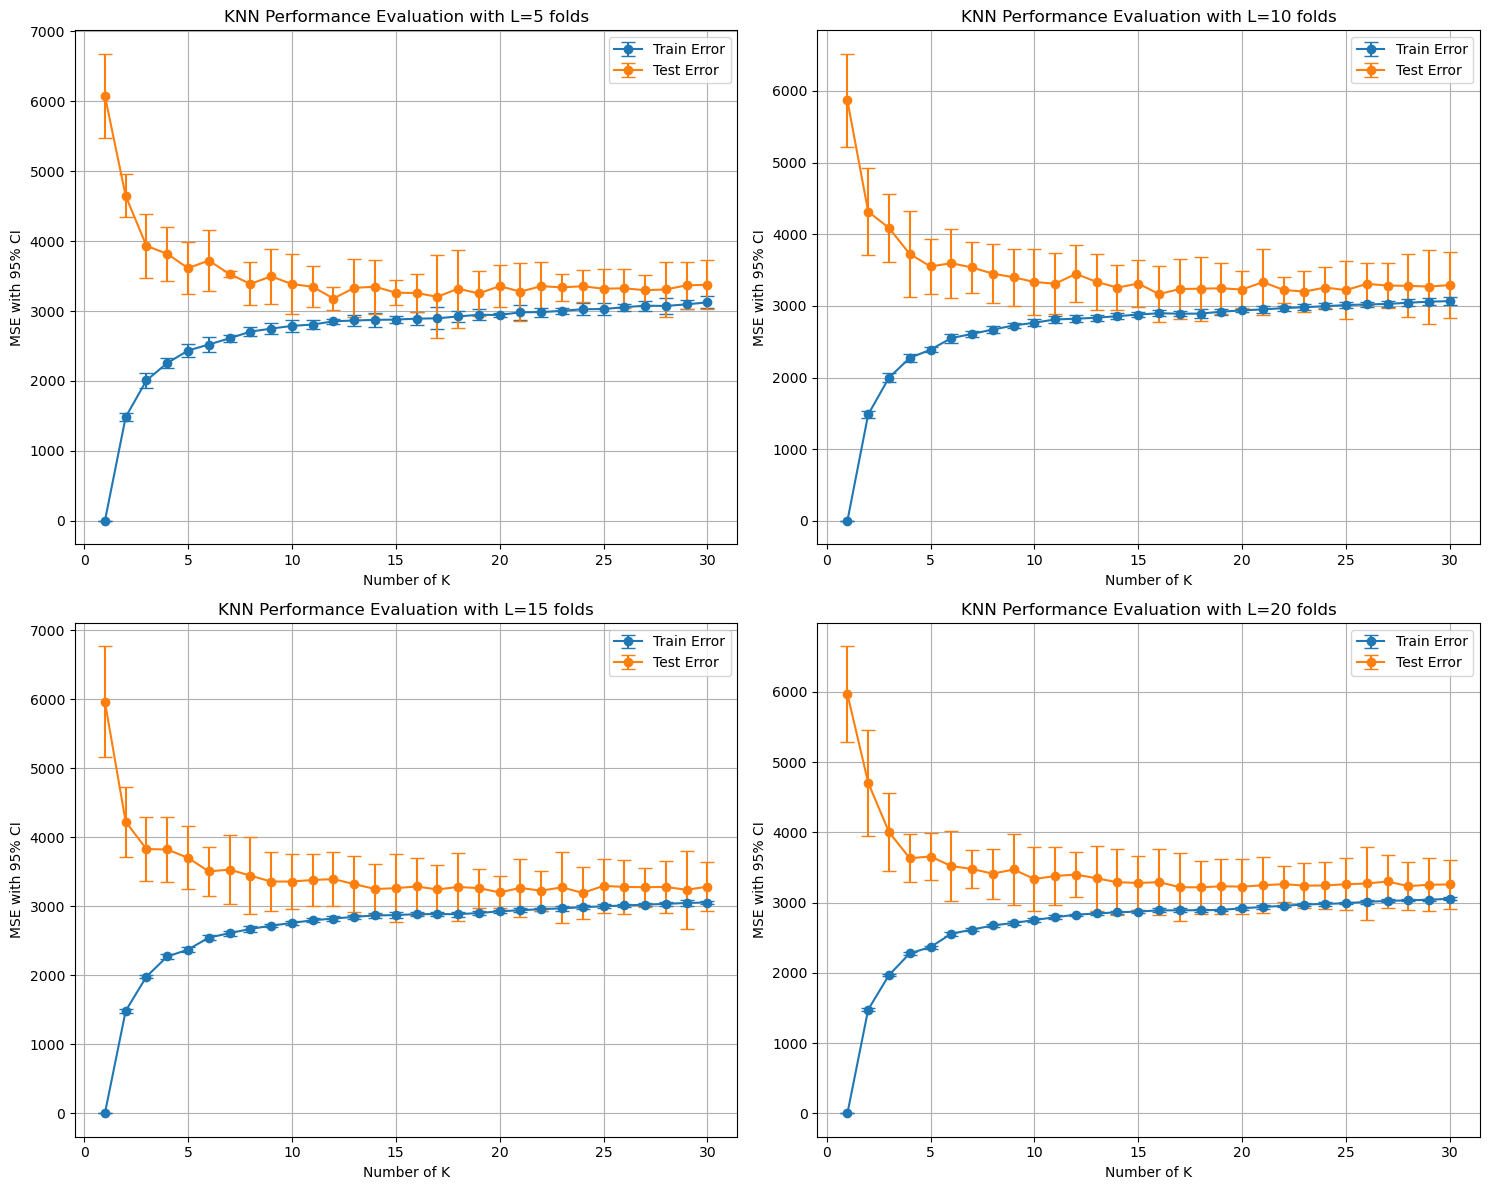

In [19]:
# Load data
X, y = diabetes.data, diabetes.target

# Different values for L to test
L_values = [5, 10, 15, 20]

# Create subplots for each L value
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

# Perform L-fold cross-validation and plot results for each L value
for i, L in enumerate(L_values):
    plt.sca(axs[i]) # Set the current axes to the i-th subplot
    results = lfold_cv(X, y, max_k=30, folds=L) # Perform cross-validation with current L value
    plot_knn_performance(results, folds=L) # Plot the KNN performance for this L value

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Overfitting is observed when the model fits the training data too closely, failing to generalize well to unseen data. In the plots, this is evident when $K$ is very small (e.g., $K=1$). <br>
Underfitting occurs when the model is too simple to capture the underlying pattern of the data. This is observed when $K$ is between 15 to 30. <br>
As $L$ increases, the confidence intervals around the MSE estimates become narrower, indicating a higher confidence in the precision of these estimates. With more folds, each individual fold is smaller, and the model is trained and validated on more diverse subsets of the data, leading to a more reliable estimate.

## Question 3 Automatic Model Selection

### I

In [20]:
from sklearn.base import BaseEstimator

class KnnRegressorCV(BaseEstimator):
    
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks # list of k values to evaluate
        self.cv = cv # Cross-validation strategy
        self.k_ = None # The optimal value of k (determined after fitting)
        
    def fit(self, x, y):
        avg_scores = {} # Dictionary to store the average MSE for each k

        # Perform cross-validation for each k value
        for k in self.ks:
            scores = [] # List to store MSE for each fold
            for train_idx, test_idx in self.cv.split(x):
                # Split the data into training and test sets based on the current fold
                x_train, x_test = x[train_idx], x[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # Initialize and fit the KNN regressor with the current k
                knn = KnnRegressor(k)
                knn.fit(x_train, y_train)

                # Predict on the test set and calculate MSE 
                y_hat_test = knn.predict(x_test)
                scores.append(mean_squared_error(y_test, y_hat_test))

            # Store the average MSE for the current k
            avg_scores[k] = np.mean(scores)

        # Determine the k value with the lowest average MSE 
        self.k_ = min(avg_scores, key=lambda x: avg_scores[x])

        # Train the final model using the entire dataset with the optimal k
        self.model_ = KnnRegressor(self.k_)
        self.model_.fit(x, y)
        return self
    
    def predict(self, x):
        return self.model_.predict(x)

### II

In [22]:
def nested_cross_validation(x, y):
    outer_cv = LFold(5) # Outer 5-fold cross-validation

    inner_ks = [] # List to store k values selected by internal cross-validation
    outer_ks = [] # List to store k values that perform best on external test sets

    # Outer loop: Iterate over each fold of the outer cross-validation
    for train_idx, test_idx in outer_cv.split(x):
        # Split the data into training and test sets
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner loop: Use cross-validation within the training set to select the best k
        knn_cv = KnnRegressorCV()
        knn_cv.fit(x_train, y_train)

        # Store the k value selected by the internal cross-validation
        inner_ks.append(knn_cv.k_)

        # List to store test errors for each k value in the outer loop
        outer_test_err = []

        # Evaluate all possible k values (1 to 20) on the external test set
        for k in range(1, 21):
            knn = KnnRegressor(k)
            knn.fit(x_train, y_train)
            y_hat_test = knn.predict(x_test)
            outer_test_err.append(mean_squared_error(y_test, y_hat_test))

        # Store the k value that results in the lowest test error on the external test set
        outer_ks.append(np.argmin(outer_test_err) + 1) # Adding 1 because np.argmin returns 0-based index
        
    return inner_ks, outer_ks

In [23]:
# Perform nested cross-validation on the diabetes dataset
inner_ks, outer_ks = nested_cross_validation(diabetes.data, diabetes.target)

# Output the results
print('Inner k values selected by internal cross-validation:', inner_ks)
print('Outer k values observed as best on external test sets:', outer_ks)
print('Mean k value chosen by internal cross-validation:', np.mean(inner_ks))
print('Mean k value that performs best on outer test sets:', np.mean(outer_ks))

Inner k values selected by internal cross-validation: [18, 17, 12, 18, 19]
Outer k values observed as best on external test sets: [6, 19, 16, 15, 20]
Mean k value chosen by internal cross-validation: 16.8
Mean k value that performs best on outer test sets: 15.2


The mean $K$ value from internal cross-validation is 16.8. This suggests that, on average, the internal cross-validation tends to favor a higher number of neighbours. The mean $K$ value determined by the outer cross-validation to be best is 15.2. This indicates that a slightly lower number of neighbours tends to perform better on unseen test data compared to what was estimated internally. There is a noticeable discrepancy between the $K$ values chosen internally and those proven optimal on the outer test sets. For instance, very low $K$ value like 6 that performed best on one of the outer test sets are never chosen by the internal cross-validation, which leans towards higher values.

Several factors can determine the effectiveness of internal cross-validation in selecting a model that would also perform best on unseen data:
- Bias in data split: If the data splits used in internal cross-validation are not representative of the overall dataset, the chosen $K$ might not generalise well.
- Variance in data: High variance within the dataset can lead to different subsets of data leading to different optimal $K$ values. This variance might cause internal cross-validation to favor a $K$ that works well on average across folds but not on specific outer test sets.
- Stability of the Algorithm: KNN is sensitive to the choice of $K$ and the distance metric used. The stability of KNN can vary based on the presence of outliers and the overall feature distribution.
- Evaluation metric: The choice of the metric used to evaluate model performance in cross-validation can influence the selected $K$. If the metric does not align well with dataset characteristics, it may not guide to the best model choice.